# Логистическая регрессия

In [1]:
# Отношение шансов (odds ratio, OR) p/(1-p), p - вероятность положительного события
# функция логит - logit(p) = log(p/(1-p))
# Нас интересует вероятность, что определённый образец принадлежит отдельно взятому классу
# логистическая функция, сигмоида - phi(z) = 1/(1+exp(-z))
# z - чистый вход, т.е. линейная комбинация весов и признаков в образце, которую можно вычислить
# как z = <b>omega</b>^T<b>x</b> = omega_0*x_0 + omega_1*x_1 + ... + omega_m*x_m

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)


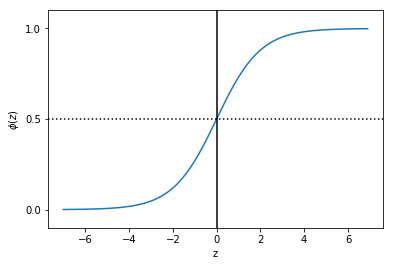

In [9]:
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.axhspan(0.0, 1.0, facecolor='1.0', alpha=0.1, ls='dotted')
plt.axhline(y=0.5, ls='dotted', color='k')
plt.yticks([0.0, .5, 1.0])
plt.ylim(-0.1, 1.1)
plt.xlabel("z")
plt.ylabel('$\phi (z)$')
plt.show()

In [35]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
data = iris.data
target_names = iris.target_names
target = iris.target
feature_names = iris.feature_names



X = data[:, [2,3]] # Забираем третью и четвёртую колонки
y = target
np.unique(y) # Показывает категории

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# sc.fit(X_train) # Считает эмперическое среднее (ню) и стандартное отклонение (сигма)
# для каждой размерности признаков
# Стандартизирование значений, используя ню и сигма из предыдущего значения
# X_train_std = sc.transform(X_train) 
# X_test_std = sc.transform(X_test)   
# Если нужно меньше писать, ниже в две строчки
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)


In [12]:


from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # Настраиваем генератор маркеров и палитру
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Вывод поверхности решения
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    # предсказываем класс каждой точки для окрашивания в соответствующий цвет
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T) # ravel делает массив 1D
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # показать все образцы
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)
        # вылелить тестовые образцы
        
        if test_idx:
            X_test, y_test = X[test_idx, :], y[test_idx]
            plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                       alpha=1.0, linewidths=1, marker='o',
                       s=55, label='Тестовый набор')



In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0) # С=1/lambda - обратный пар-тр регуляризации
lr.fit(X_train_std, y_train)



LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

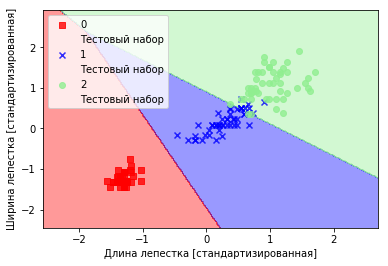

In [17]:
X_combined_std = np.vstack([X_train_std, X_test_std])
y_combined_std = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined_std,
                     classifier=lr,
                     test_idx=range(105,150))
plt.xlabel("Длина лепестка [стандартизированная]")
plt.ylabel("Ширина лепестка [стандартизированная]")
plt.legend(loc='upper left')
plt.show()

In [40]:
lr.predict_proba([X_train_std[14,:]])

array([[3.68342588e-10, 1.79767482e-01, 8.20232518e-01]])

In [41]:
# Дисперсия измеряет постоянство (или изменчивость) модельного прогноза для отдельно взятого 
# экземпляра при многократном переобучении модели, например, на разных подмножествах
# тренировочного набора данных. При этом мы можем говорить, что модель чувствительна
# к случайности в тренировочных данных. В отличие от дисперсии, смещение измеряет, как далеко 
# прогнозы находятся от правильных значений в целом при многократной перестройке модели на 
# разных тренировочных наборах данных; смещение является мерой систематической ошибки, которая 
# не происходит в силу случайности

# Один из хороших способов найти хороший компромис между смещением и дисперсией состояит в том, 
# чтобы настроить сложность модели посредством регуляризации. Регуляризация - полезный метод 
# для обработки коллинеарности (высокой корреляции среди признаков), фильтрации шума из данных 
# и, в конечном счёте, предотвращения переобучения. В основе регуляризации лежит идея внесения
# дополнительной информации (смещения) для наложения штрафа на экстремальные веса параметров. 
# Самой стандартной формой регуляризации является L2-регуляризация весов



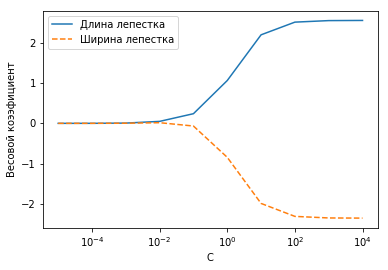

In [54]:
weights, params = [], []
for c in np.arange(-5, 5, 1, dtype=float):
    lr = LogisticRegression(C=np.power(10,c), random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='Длина лепестка')
plt.plot(params, weights[:, 1], '--', label='Ширина лепестка')
plt.ylabel('Весовой коээфициент')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()